In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("cs1090a_hw4.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS1090A Introduction to Data Science: 
## Homework 4: Classification: Predicting College Admissions

**Harvard University**<br/>
**Fall 2024**<br/>
**Instructors**: Pavlos Protopapas and Natesh Pillai

<hr style="height:2.4pt">

In [2]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2021-CS109A/master/"
    "themes/static/css/cs109.css"
).text
HTML(styles)

<div style = "border: thin solid black; border-radius: 2px; padding: 5px">

### Instructions
- To submit your notebook, follow the instructions given in on the Canvas assignment page.
- Plots should be legible and interpretable *without having to refer to the code that generated them*. They should include labels for the $x$- and $y$-axes as well as a descriptive title and/or legend when appropriate.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you believe the plot *means*.
- Autograding tests are mostly to help you debug. The tests are not exhaustive so simply passing all tests may not be sufficient for full credit.
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. Please get course staff approval before importing any additional 3rd party libraries.
- Enable scrolling output on cells with slighlty longer output. Avoid excessively long output.
- Feel free to add additional code or markdown cells as needed.
- Don't forget to include a written response when one is requested by a question prompt.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells (note that this can take a few minutes). 
- **You should do a "Restart Kernel and Run All Cells" before submitting to ensure (1) your notebook actually runs and (2) all output is visible**
</div>

### Import Libraries

In [3]:
# RUN THIS CELL
import itertools
import math
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

In [4]:
# For calculating total notebook runtime
notebook_start = time.time()

<a id="contents"></a>

## Notebook contents

- [**Overview and data description**](#intro)


- [**Question 1: Data exploration using train and basic models**](#part1)

- [**Question 2: Interpretable modeling**](#part2)

- [**Question 3: Harvard and Yale?**](#part3)

- [**Question 4: Building predictive models for admitted**](#part4)

- [**Question 5: Evaluating results**](#part5)

- [**Question 6: BONUS!**](#part6)

<a id="intro"></a>

## Overview and data description

[Return to contents](#contents)

### Predicting admissions into elite universities

In this problem set we will model the chances of high school students being accepted into two different elite undergraduate colleges: Harvard and Yale.

The data are provided in the file `data/college_admissions.csv` and were scraped in 2022 from [collegedata.com](https://www.collegedata.com/) (where applicants volunteer to share their information).  Each observation corresponds to an applicant to one of the two different colleges (note: the same applicant may show up in two rows: once for each college).  The main response is the `"admitted"` variable (1 = admitted, 0 = denied), and there are are several predictors to consider:

- **id**: a unique identifier for the applicant 
- **test_score**: a standardized measurement of the applicant's highest ACT or SAT combined score (2400 is the maximum)
- **ap**: the number of AP tests taken
- **avg_ap**: the average score on the AP tests taken (0 if no tests were taken)
- **sat_subjects**: the number of SAT subject tests taken
- **gpa**: the unweighted GPA of the applicant (max of 4.0)
- **female**:  a binary indicator for gender: 1 = female, 0 = otherwise
- **minority**: a binary indicator for under-represented minority: 1 = minority, 0 = otherwise 
- **international**: a binary indicator for international status: 1 = international, 0 = United States
- **sports**: a binary indicator for High School All-American: 1 = all-American athlete, 0 = otherwise
- **harvard**: a categorical variable for school applied to: 1 = Harvard, 0 = Yale
- **early_app**: a binary indicator for application type: 1 = early action, 0 = regular
- **alumni**:  a binary indicator for parents' alumni status of school: 1 = a parent is an alumnus, 0 = otherwise
- **program**: the program applied to by the student with many choices (we will not use this as a predictor)
- **add_info**: additional (optional) info provided by applicant (we will not use this as a predictor)

**The main set of 12 predictors is:**

```python
[
    "test_score", "ap", "avg_ap", "sat_subjects", 
    "gpa", "female", "minority", "international",
    "sports", "harvard", "early_app", "alumni",
]
```

Please note, you may need to modify this list when fitting different models.


**IMPORTANT NOTES:**

- Unless stated otherwise, all logistic regression models should be unregularized (use `penalty=None`) and include the intercept (which is the default in `sklearn`).


- When printing your output (e.g. coefficients, accuracy scores, etc.), DO NOT just print numbers without context. Please be certain provide clarifying labels for all printed numbers and limit the number of digits showing after decimals to a reasonable length (e.g. 4 decimal points for coefficients and accuracy scores).


- Also be sure to practice good data science principles: always use train to do analysis and never touch the test set until the very end.

---

<a id="part1"></a>

## <div class='exercise'>Question 1: Data exploration using train and basic models</div>

[Return to contents](#contents)

The first step is to split the observations into an approximate 80-20 train-test split.  Below is some code to do this for you (we want to make sure everyone has the same splits). It also prints the dataset's shape before splitting and after splitting. 

**IMPORTANT:** While an argument could be made to scale our predictors here, please **DO NOT** do so **UNTIL** it is requested of you in **[Question 4.1](#part4)**.


In [5]:
#############################
## DO NOT MODIFY THIS CODE ##
#############################
np.random.seed(121)

college = pd.read_csv("data/college_admissions.csv")

college_train, college_test = train_test_split(
    college,
    test_size=0.2,
    random_state=121,
    shuffle=True,
    stratify=college["admitted"],
)

print(college.shape)
print(college_train.shape, college_test.shape)
display(college_train.head())
college_train.info()

# Separate predictors from response
X_train, y_train = college_train.drop(columns=["admitted"]), college_train["admitted"]
X_test, y_test = college_test.drop(columns=["admitted"]), college_test["admitted"]

(1871, 16)
(1496, 16) (375, 16)


,id,admitted,test_score,ap,avg_ap,sat_subjects,gpa,female,minority,international,sports,early_app,alumni,program,add_info,harvard
192,NYFN0GE0KK,1,2310,7,5.000,5,3.98,0,0,0,0,0,0,Economics,Activities Activity Position Honors Grade Levels Approximate Time When Participated Participate ...,1
652,50FWDZ3MBF,1,2010,3,4.333,3,3.75,1,1,0,0,0,0,History Political Science,Drama Club Co founder of a Community Outreach Organization called Los Amigos volunteered helped ...,1
593,KYYHQRHBV9,0,2080,5,4.200,2,3.85,0,0,0,0,0,0,Biology Pre Med,moderate a few sports and clubs and a part time jobfamily circumstances positive,1
331,JQ8O4AV4VM,0,2250,0,0.000,2,4.00,0,0,0,0,0,0,Physics,NaN,1
1117,SJUQZVBA7K,0,2230,4,4.000,5,3.96,1,0,0,0,1,0,Chemistry Chemical Engineering,MUN Advisor 12 10 National Honors Society 12 10 California Scholarship Federation 12 9 Book Club...,0


<class 'pandas.core.frame.DataFrame'>
Index: 1496 entries, 192 to 1296
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1496 non-null   object 
 1   admitted       1496 non-null   int64  
 2   test_score     1496 non-null   int64  
 3   ap             1496 non-null   int64  
 4   avg_ap         1496 non-null   float64
 5   sat_subjects   1496 non-null   int64  
 6   gpa            1496 non-null   float64
 7   female         1496 non-null   int64  
 8   minority       1496 non-null   int64  
 9   international  1496 non-null   int64  
 10  sports         1496 non-null   int64  
 11  early_app      1496 non-null   int64  
 12  alumni         1496 non-null   int64  
 13  program        1298 non-null   object 
 14  add_info       949 non-null    object 
 15  harvard        1496 non-null   int64  
dtypes: float64(2), int64(11), object(3)
memory usage: 198.7+ KB


<div class='exercise-r'>

**Q1.1** Consider a baseline, "naive" model that predicts that *ALL* applicants belong to the same class. This class prediction is *not* determined by an applicant's feature values, but rather by the proportion of observations in the training data belonging to each class.

Calculate the accuracy of this naive model on the training data and store it in `naive_train_acc`.
    
**NOTE:** For this assignment, use the convention that accuracies range from 0 to 1 (to be consistant with sklearn).
    
</div>

In [6]:
# your code here

# calculate proportion of people that are rejected
naive_train_acc = 1 - y_train.mean()

In [7]:
print("Naive Classification Model Based on Training Proportions")
print(f"\tTrain Accuracy: {naive_train_acc:.4f}")

Naive Classification Model Based on Training Proportions
	Train Accuracy: 0.7299


In [8]:
grader.check("q1.1")

q1.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q1.2** Let's investigate how each of our 12 predictors is associated with whether or not an applicant is admitted into the college to which they applied (`admitted`). To this end, create a separate **visual** for each of our predictors to investigate their relationship with college admissions. **Suggestion:** Place these 12 visuals in a grid of subplots with 3 columns and 4 rows.

</div>

In [9]:
# for numerical predictors, we will use violin plots
# for categorical predictors, we will use bar plots showing admissions rate

In [10]:
# set plot configuration parameters
plot_configs = {
    "test_score": {
        "title": "SAT/ACT Scores by Admission Status",
        "xlabel": "Admission Status",
        "ylabel": "Standardized Test Score"
    },
    "ap": {
        "title": "Number of AP Tests by Admission Status",
        "xlabel": "Admission Status",
        "ylabel": "Number of AP Tests"
    },
    "avg_ap": {
        "title": "Average AP Score by Admission Status",
        "xlabel": "Admission Status",
        "ylabel": "Average AP Score"
    },
    "sat_subjects": {
        "title": "SAT Subject Tests by Admission Status",
        "xlabel": "Admission Status",
        "ylabel": "Number of SAT Subject Tests"
    },
    "gpa": {
        "title": "GPA Distribution by Admission Status",
        "xlabel": "Admission Status",
        "ylabel": "Unweighted GPA"
    },
    "female": {
        "title": "Proportion Female by Admission Status ",
        "xlabel": "Admission Status",
        "ylabel": "Percent Female"
    },
    "minority": {
        "title": "Percent Minority by Admission Status",
        "xlabel": "Admission Status",
        "ylabel": "Percent Minority"
    },
    "international": {
        "title": "Percent International by Admission Status",
        "xlabel": "Admission Status",
        "ylabel": "Percent International"
    },
    "sports": {
        "title": "Percent Athlete by Admission Status",
        "xlabel": "Admission Status",
        "ylabel": "Percent Athlete"
    },
    "harvard": {
        "title": "Percent Applied to Harvard by Admission Status",
        "xlabel": "Admission Status",
        "ylabel": "Percent Applied to Harvard"
    },
    "early_app": {
        "title": "Percent Early by Admission Status",
        "xlabel": "Admission Status",
        "ylabel": "Percent Early"
    },
    "alumni": {
        "title": "Percent Legacy by Admission Status",
        "xlabel": "Admission Status",
        "ylabel": "Percent Legacy"
    }
}

/var/folders/9c/7d5d4vv50tlg0qp7ks_m2mtc0000gn/T/ipykernel_13802/4162669625.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Not Admitted', 'Admitted'], rotation=0)
/var/folders/9c/7d5d4vv50tlg0qp7ks_m2mtc0000gn/T/ipykernel_13802/4162669625.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Not Admitted', 'Admitted'], rotation=0)
/var/folders/9c/7d5d4vv50tlg0qp7ks_m2mtc0000gn/T/ipykernel_13802/4162669625.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Not Admitted', 'Admitted'], rotation=0)
/var/folders/9c/7d5d4vv50tlg0qp7ks_m2mtc0000gn/T/ipykernel_13802/4162669625.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

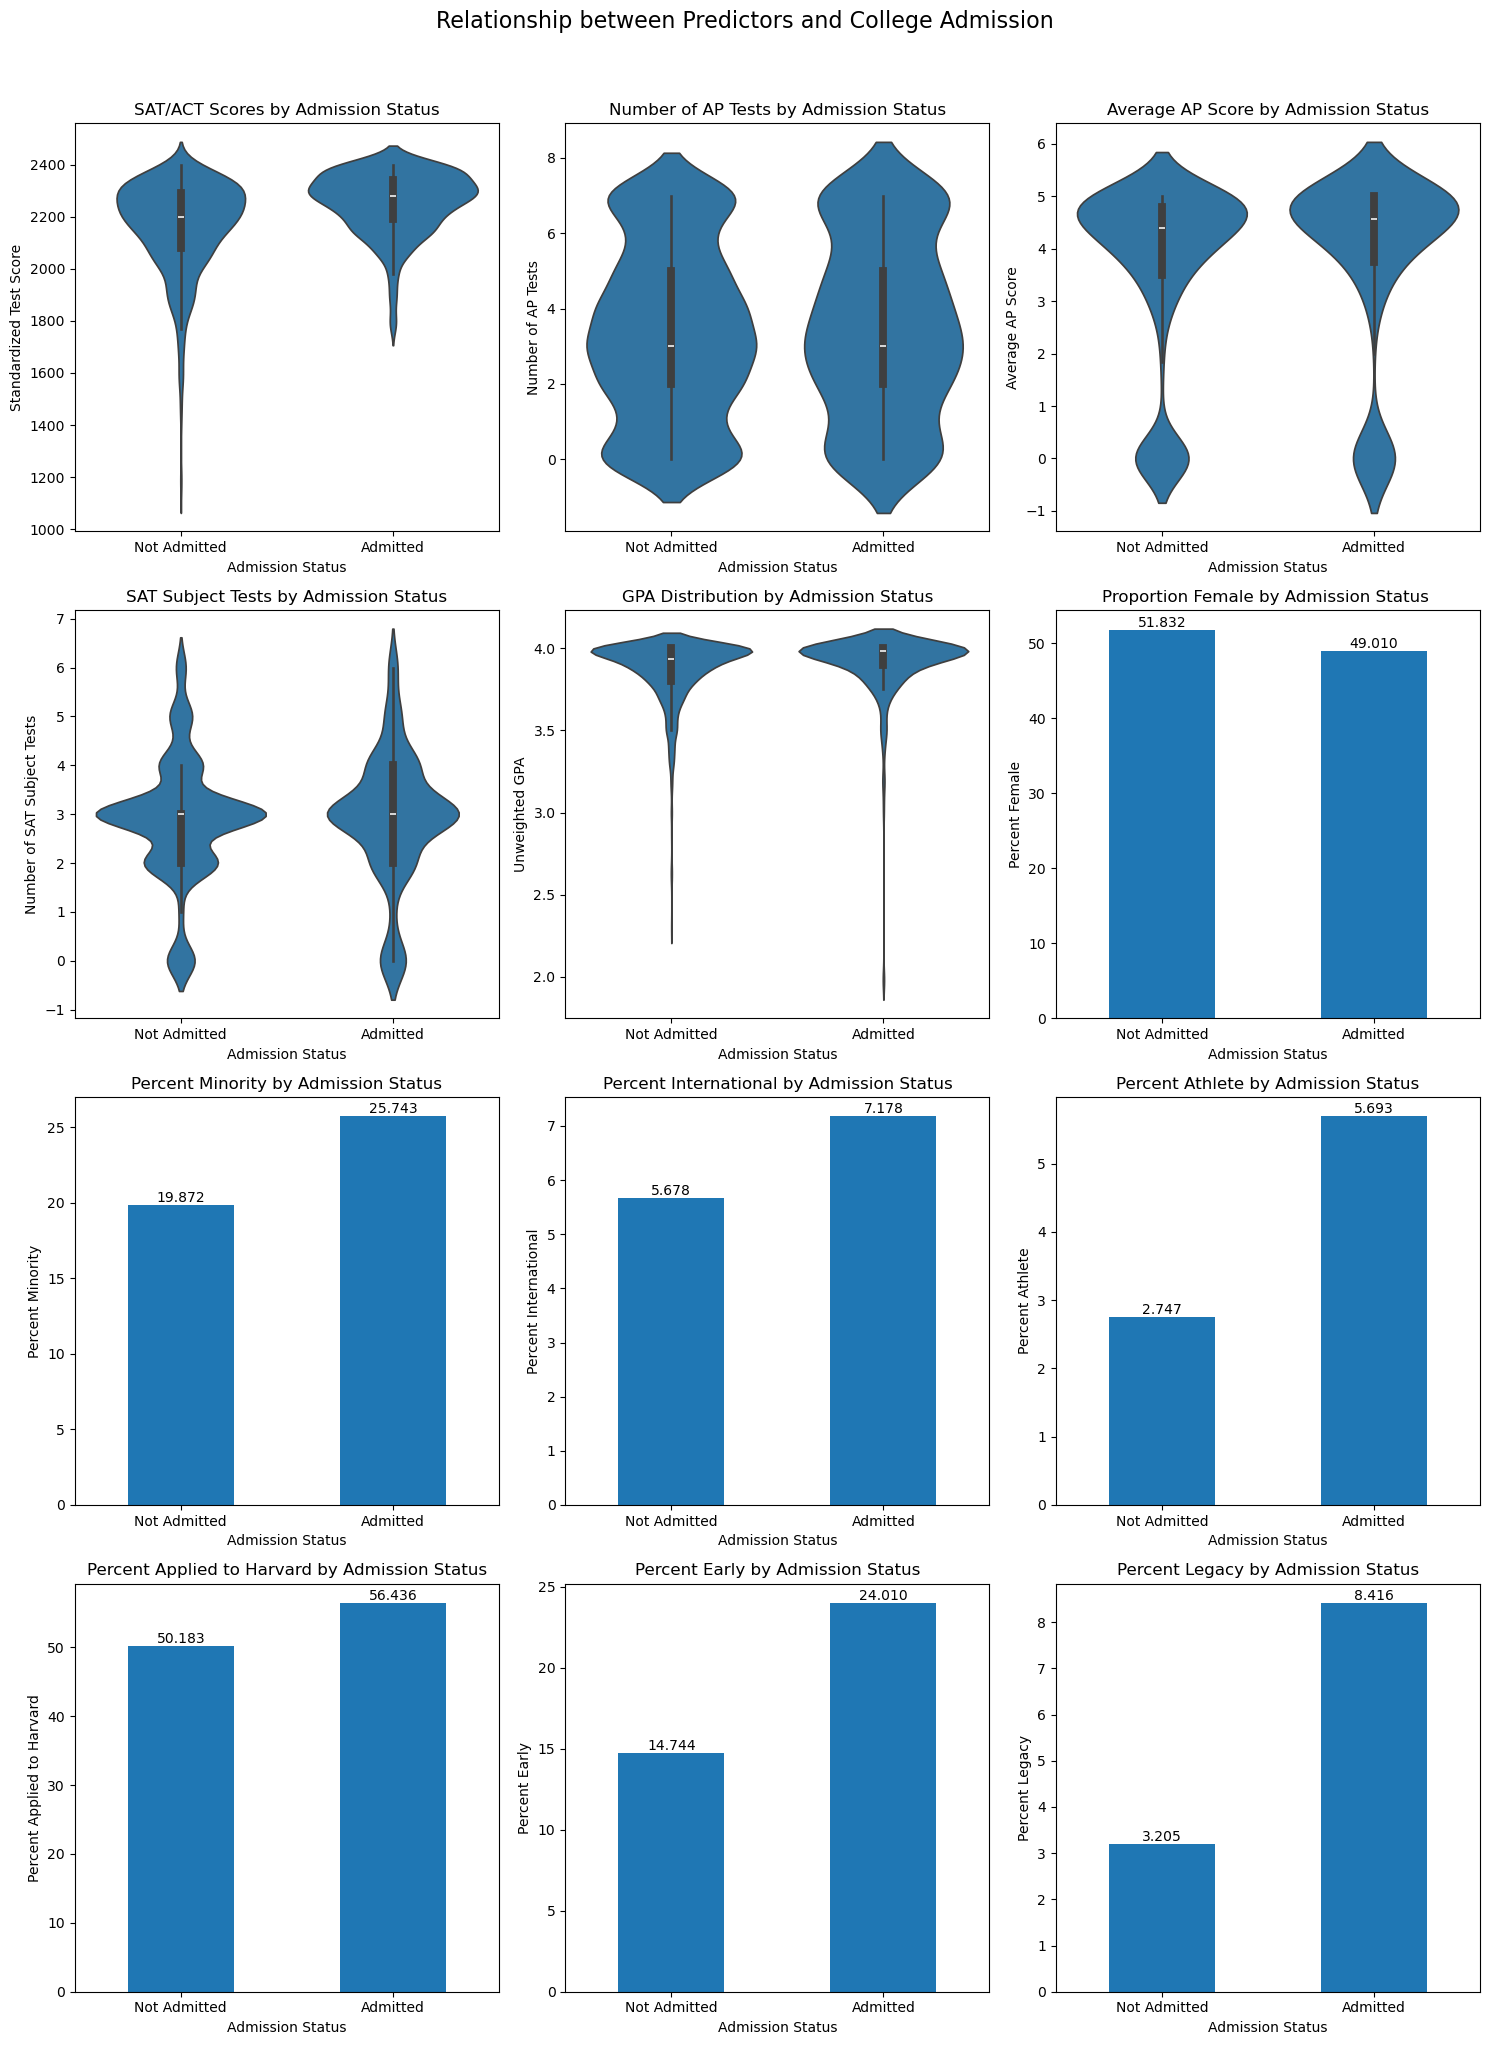

In [11]:
# subplots
fig, axes = plt.subplots(4, 3, figsize=(15, 20))
fig.suptitle('Relationship between Predictors and College Admission', fontsize=16, y=1.02)

axes = axes.flatten()

# predictors
predictors = [
    "test_score", "ap", "avg_ap", "sat_subjects", 
    "gpa", "female", "minority", "international",
    "sports", "harvard", "early_app", "alumni"
]

# gen da plots
for i, predictor in enumerate(predictors):
    if predictor in ["test_score", "ap", "avg_ap", "sat_subjects", "gpa"]:
        # violin plots for numerical predictors
        sns.violinplot(data=college_train, x="admitted", y=predictor, ax=axes[i])
    else:
        # bar plots for categorical predictors. calculate proportion of each category within admitted/non-admitted groups
        proportions = college_train.groupby('admitted')[predictor].mean() * 100
        proportions.plot(kind='bar', ax=axes[i])
        
        # add value labels
        for j, v in enumerate(proportions):
            axes[i].text(j, v, f'{v:.3f}', ha='center', va='bottom')
            
    axes[i].set_title(plot_configs[predictor]["title"])
    axes[i].set_xlabel(plot_configs[predictor]["xlabel"])
    axes[i].set_ylabel(plot_configs[predictor]["ylabel"])
    axes[i].set_xticklabels(['Not Admitted', 'Admitted'], rotation=0)

plt.tight_layout()
plt.show()




<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**1.3** Based on the visuals above, which predictor seems to have the most potential for predicting `admitted`? Why do you think this it the best potential single predictor?
    
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

Among the numerical variables, the best predictor appears to be test score. This is because the distribtuion of test scores for the admitted people looks very different --- much more condensed and clustered --- than the distribution for the non-admitted people. This creates a floor for the test scores whereby the college does not admit students whose test scores are below a certain point, which can help with classification.

Among the categorical variable, the early application predictor appears to have the most potential for predicting admission. It shows the most dramatic difference between admitted and non-admitted groups, with early applicants being admitted at a notably higher rate (24.0% of admitted students applied early vs only 14.7% of non-admitted students - a difference of about 9.3 percentage points).

This pattern suggests that applying early is strongly associated with admission outcomes, making it potentially the most useful single predictor among those shown.

It makes sense that test scores and early application are the best predictors.

For test scores, the test is specifically designed as a diagnostic for universities to use to determine admission. Test scores accurately gauge competence. 

For early admissions, it also makes sense. If you apply early, then the college knows that you are committed to attend, which makes you more likely to be admitted.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>
    
**Q1.4** Fit a logistic regression to predict `admitted` from `harvard` (call it `logit1_4`).  
- Store the coefficient and intercept in `logit1_4_coef` and `logit1_4_intercept`. Interpret these values.
- Use $\LaTeX$ to demonstrate how you can use these coefficient values to calculate the estimated probabilities of getting into each school.
- Store the results of the above calculation in `p_harvard` and `p_yale`. 
- Which school is easier to get into according to this model?

**IMPORTANT:** 
- Remember, all models in this assignment should be **unregularized** unless you are specifically asked to use regularization for a particular model.
- Use `random_state = 109` for all of your `LogisticRegression` and `LogisticRegressionCV` models in this notebook.
</div>

In [12]:
# your code here
seed = 109
# Fit logistic regression model without regularization
logit1_4 = LogisticRegression(penalty = None, random_state = seed).fit(X_train[['harvard']], y_train)

# Identify and report coefficients
logit1_4_coef = logit1_4.coef_[0][0]
logit1_4_intercept = logit1_4.intercept_[0]

# Calculate and report probabilities
p_harvard = 1 / (1 + np.exp(-(logit1_4_intercept + logit1_4_coef)))
p_yale = 1 / (1 + np.exp(-(logit1_4_intercept)))

In [13]:
print(
    "The coefficient for the 'logit1_4' model's only predictor 'harvard' "
    "is {:.4f} and the intercept is {:.4f}\n".format(
        logit1_4_coef, logit1_4_intercept
    )
)

print(
    "Estimated probability of acceptance for Harvard: {:.4f}"
    .format(p_harvard)
)
print(
    "Estimated probability of acceptance for Yale: {:.4f}"
    .format(p_yale)
)

The coefficient for the 'logit1_4' model's only predictor 'harvard' is 0.2512 and the intercept is -1.1280

Estimated probability of acceptance for Harvard: 0.2938
Estimated probability of acceptance for Yale: 0.2445


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

Interpretation:
- The intercept represents the log-odds of admission when harvard = 0 (i.e., for applying to Yale)
- The coefficient represents the change in log-odds of admission when harvard = 1 (vs. Yale)

Here is the math for getting probabilities from coefficients:
- For Yale (harvard = 0):
$P(\text{admitted}|\text{Applied to Yale}) = \frac{1}{1 + e^{-(\beta_0)}}$

- For Harvard (harvard = 1):
$P(\text{admitted}|\text{Applied to Harvard}) = \frac{1}{1 + e^{-(\beta_0 + \beta_1)}}$

According to this model, it is easier to get into Harvard.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [14]:
grader.check("q1.4")

q1.4 results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q1.5** Create and display a [contingency table](https://en.wikipedia.org/wiki/Contingency_table) between `admitted` and `harvard`.  Use this table to calculate and confirm the coefficient estimates in the `logit1_4` model (both the intercept and slope). Show this calculation using $\LaTeX$ in a markdown cell.
    
**Hint:** The Pandas [crosstab](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.crosstab.html) method may be helpful here.

</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

The probability of admission to Yale is $\frac{176}{720} = 0.244$, so the log odds of admission is $\ln(\frac{.244}{1-.244}) = -1.128$.

The probability of admission to Harvard is $\frac{228}{776} = 0.294$, so the log odds of admission is $\ln(\frac{.294}{1-.294}) = -0.876$

$\beta_0$ is the log odds of admission to Yale, so $\beta_0 = -1.128$. $\beta_0 + \beta_1$ is the log odds of admission to Harvard, so $\beta_1 = -0.876 - (-1.128) = .2512$.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [15]:
cont_table = pd.crosstab(college_train['admitted'], college_train['harvard'])
display(cont_table)

harvard,0,1
admitted,,
0,544,548
1,176,228


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q1.6** Compare the estimated probabilities of being admitted into the schools to the overall acceptance rate (as seen [here](https://www.ivycoach.com/2022-ivy-league-admissions-statistics/)).  Why may what you've observed in this comparison be the case?
    
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

It makes sense that the probability of being admitted to these two top schools is higher than the overall acceptance rate because the data comes from a website where people voluntarily report their statistics. As a result, there is likely a bias toward people who got into these top schools, rather than people who got rejected.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

---

<a id="part2"></a>

## <div class='exercise'>Question 2: Interpretable modeling</div>

[Return to contents](#contents)

<div class='exercise-r'>

**Q2.1** 
    
- Fit a logistic regression model to predict `admitted` from `test_score` alone. Call it `logit2_1`.
- Store the learned parameters in `logit2_1_intercept` and `logit2_1_coef_test_score`. 
- Store the train accuracy and mean 10-fold cross-validation accuracy in `acc_train_logit2_1` and `acc_cv_logit2_1`.

**Note:** The coefficients and train accuracies should come from a model fit on all the training data. To calculate the mean 10-fold cross-validation accuracy, use `cross_val_score`. This should be the strategy used throughout the notebook except when using `LogisticRegressionCV` in later questions (since this model already gives you CV scores "for free"). Will will assume 10 folds whenever we cross-validate in this notebook.
</div>

In [16]:
# your code here
logit2_1 = LogisticRegression(penalty = None, random_state = seed).fit(X_train[['test_score']], y_train)

logit2_1_intercept = logit2_1.intercept_[0]
logit2_1_coef_test_score = logit2_1.coef_[0][0]

acc_train_logit2_1 = logit2_1.score(X_train[['test_score']], y_train)
acc_cv_logit2_1 = cross_val_score(logit2_1, X_train[['test_score']], y_train, cv=10).mean()

In [17]:
print("The intercept and coefficient for the 'logit2_1' model are:")

print("\t{:<20}{:.4f}".format('intercept', logit2_1_intercept))
print("\t{:<20}{:.4f}".format('test_score', logit2_1_coef_test_score))

print(
    "\nThe classification accuracies for 'logit2_1' are:"
    "\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}".format(
        acc_train_logit2_1, acc_cv_logit2_1
    )
)

The intercept and coefficient for the 'logit2_1' model are:
	intercept           -10.5474
	test_score          0.0043

The classification accuracies for 'logit2_1' are:

	Train	0.7299
	CV	0.7300


In [18]:
grader.check("q2.1")

q2.1 results: All test cases passed!

<div class='exercise-r'>

**Q2.2**
    
- What is the estimated probability of an applicant being admitted with a `test_score` of 2250? Store this in `prob_test_2250`.
- What about if they had a perfect test score of 2400? Store this in `prob_test_2400`.
- What test score would be needed to have a 50-50 chance (i.e. 0.5 probability) of being admitted? Store this in `test_50_50`.
    
</div>

In [19]:
# your code here
prob_test_2250 = 1 /(1 + np.exp(-(logit2_1_intercept + logit2_1_coef_test_score*2250)))
prob_test_2400 = 1 /(1 + np.exp(-(logit2_1_intercept + logit2_1_coef_test_score*2400)))

test_50_50 = -(logit2_1_intercept / logit2_1_coef_test_score)

In [20]:
print(
    "The estimated chances of an applicant being admitted with "
    "the following two 'test' scores:\n\n\tscore\tprobabilities"
    "\n\t2250\t{:.4f}\n\t2400\t{:.4f}\n"
    .format(prob_test_2250, prob_test_2400)
)

print(
    "The test score required to have a 50-50 chance of being "
    "admitted is approximately:\n\n\t{:.2f}"
    .format(test_50_50)
)

The estimated chances of an applicant being admitted with the following two 'test' scores:

	score	probabilities
	2250	0.3019
	2400	0.4525

The test score required to have a 50-50 chance of being admitted is approximately:

	2444.20


In [21]:
grader.check("q2.2")

q2.2 results: All test cases passed!

<div class='exercise-r'>

**Q2.3** Fit a logistic regression model to predict `admitted` from `test_score` and `avg_ap` (call it `logit2_3`).  Store the train and mean cv accuracies calculated as before in `acc_train_logit2_3` and `acc_cv_logit2_3`. Then use the provided code to print out the coefficient estimates along with the accuracy scores.
    
</div>

In [22]:
# your code here
logit2_3 = LogisticRegression(penalty = None, random_state = seed).fit(X_train[['test_score', 'avg_ap']], y_train)

logit2_3_intercept = logit2_3.intercept_[0]
logit2_3_coef_test_score = logit2_3.coef_[0][0]
logit2_3_coef_avg_ap = logit2_3.coef_[0][1]

acc_train_logit2_3 = logit2_3.score(X_train[['test_score', 'avg_ap']], y_train)
acc_cv_logit2_3 = cross_val_score(logit2_3, X_train[['test_score', 'avg_ap']], y_train, cv=10).mean()

In [23]:
# Print the results of logit2_3
print("The intercept and coefficients for the 'logit2_3' model are:")
print("\t{:<20}{:.4f}".format('intercept', logit2_3_intercept))
print("\t{:<20}{:.4f}".format('test', logit2_3_coef_test_score))
print("\t{:<20}{:.4f}".format('avg_ap', logit2_3_coef_avg_ap))

print(
    "\nThe classification accuracies for 'logit2_3' are:\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(acc_train_logit2_3, acc_cv_logit2_3)
)

The intercept and coefficients for the 'logit2_3' model are:
	intercept           -10.9086
	test                0.0046
	avg_ap              -0.0723

The classification accuracies for 'logit2_3' are:

	Train	0.7306
	CV	0.7299


In [24]:
grader.check("q2.3")

q2.3 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q2.4** Interpret the coefficient estimates for both predictors in `logit2_3` and compare the coefficient estimate for `test_score` to the one from `logit2_1`.  Why has this estimate changed?

You should inspect the relationship between `test_score` and `avg_ap` to help get a better sense for what might be happening here.

</div>

In [25]:
# Print the parameters of the last 2 models
print("The intercept and coefficient for the 'logit2_1' model are:")

print("\t{:<20}{:.4f}".format('intercept', logit2_1_intercept))
print("\t{:<20}{:.4f}".format('test_score', logit2_1_coef_test_score))

print("The intercept and coefficients for the 'logit2_3' model are:")
print("\t{:<20}{:.4f}".format('intercept', logit2_3_intercept))
print("\t{:<20}{:.4f}".format('test_score', logit2_3_coef_test_score))
print("\t{:<20}{:.4f}".format('avg_ap', logit2_3_coef_avg_ap))

The intercept and coefficient for the 'logit2_1' model are:
	intercept           -10.5474
	test_score          0.0043
The intercept and coefficients for the 'logit2_3' model are:
	intercept           -10.9086
	test_score          0.0046
	avg_ap              -0.0723


Correlation between test_score and avg_ap: 0.3878


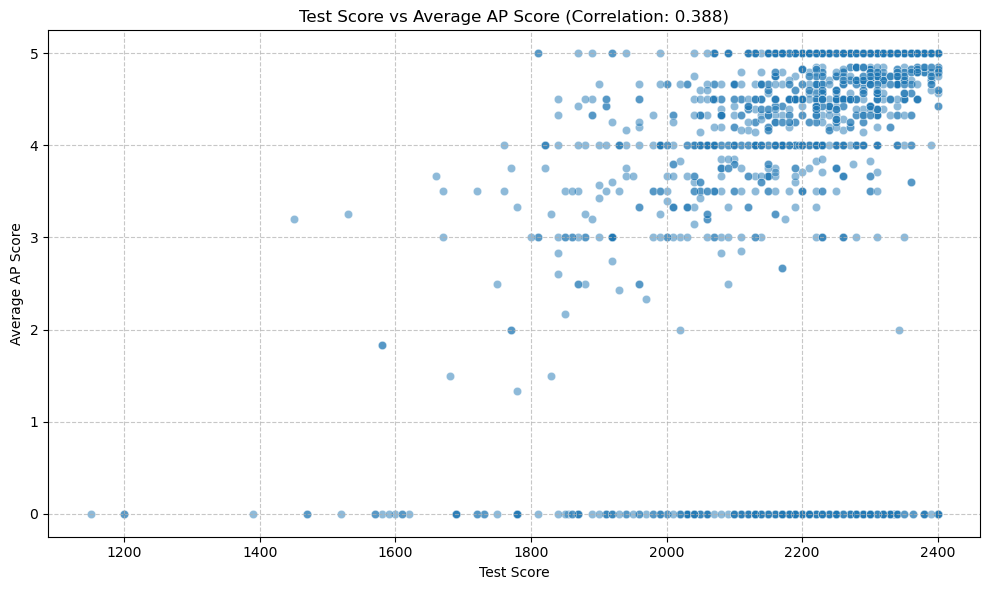

In [80]:
# get correlation between test_score and avg_ap

rho = college_train["test_score"].corr(college_train["avg_ap"])

print(f"Correlation between test_score and avg_ap: {rho:.4f}")

# Create the plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=college_train, 
                x="test_score", 
                y="avg_ap", 
                alpha=0.5)

# Customize the plot
plt.title(f'Test Score vs Average AP Score (Correlation: {rho:.3f})')
plt.xlabel('Test Score')
plt.ylabel('Average AP Score')

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()



<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

Interpretation: 
- For test_score: Holding avg_ap constant, a one-point increase in test score is associated with a .0044 increase in the log-odds of admission.
- For avg_ap: Holding test_score constant, a one-point increase in average AP score is associated with a .0723 decrease in the log-odds of admission

With the inclusion of the avg_ap variable, the coefficeint on test_score has increased 0.0003 points from 0.0043 to 0.0046. This change is due to the fact that there is collinearity between both avg_ap and test_score and between avg_ap and the probability of getting admitted. Thus, avg_ap is likely confounding the relationship between test_score and admission.

Worse, the collinearity between avg_ap and test_score is likely even higher than what was measured in the picture above. Notice that every student who did not take an ap test was given a zero, which likely erodes the predictive power of avg_ap. If these students were dropped, the collinearity would be much higher.


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [26]:
correlation = X_train['test_score'].corr(X_train['avg_ap'])
print(f"\nCorrelation between test_score and avg_ap: {correlation:.4f}")


Correlation between test_score and avg_ap: 0.3878


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q2.5** Interpret and compare the train and cv accuracies for the two models, `logit2_1` and `logit2_3`.  Explain why these accuracies are the same or different, and what about the data makes these accuracies so similar or different.

</div>

In [27]:
# Display accuracies of last 2 models
print(
    "\nThe classification accuracies for 'logit2_1' are:\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(acc_train_logit2_1, acc_cv_logit2_1)
)
print(
    "\nThe classification accuracies for 'logit2_3' are:\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(acc_train_logit2_3, acc_cv_logit2_3)
)


The classification accuracies for 'logit2_1' are:

	Train	0.7299
	CV	0.7300

The classification accuracies for 'logit2_3' are:

	Train	0.7306
	CV	0.7299


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

When we include avg_ap, we increase the number of predictors, so it makes sense that the second model fits the training data slightly better. But, in general, there are only small differences in model accuracies. Thus adding avg_ap as a predictor alongside test_score provides very little additional predictive power. This is for a few reasons:

- Multicollinearity. test_score and avg_ap are highly correlated (see above). Students who do well on standardized tests tend to also do well on AP exams. So avg_ap adds very little new information beyond what test_score already provides.
- Both variables measure similar underlying construct. Both test_score and avg_ap measure academic ability/performance, so they likely capture much of the same signal about a student's potential for admission.

Ultimately, the minimal improvement in training accuracy (0.7299 to 0.7306) and basically identical CV accuracy suggests that the addition of avg_ap only helped fit the training data slightly better, and that this small improvement didn't generalize to the validation sets in cross-validation.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

---

<a id="part3"></a>

## <div class='exercise'>Question 3: Harvard and Yale?</div>

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q3.1**
- Fit a logistic regression model (call it `logit3_1`) to predict `admitted` from 7 predictors: `["harvard", "test_score", "ap", "avg_ap", "gpa", "female", "minority"]`.
- Store the train and mean cv accuracies in `acc_train_logit3_1` and `acc_cv_logit3_1`.
- Interpret the coefficients for the binary predictors in this model.

**Hint:**
- If you have convergence warnings, increasing the maximum number of iterations will likely solve this issue.
    
</div>

In [28]:
# Print statements below assume predictors used in this order
logit3_1_predictors = ["harvard", "test_score", "ap", "avg_ap", "gpa", "female", "minority"]

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

The binary predictors are "female", which is 1 if the applicant is female and 0 otherwise, and "minority", which is 1 if the applicant is a minority and 0 otherwise.
- Female: Being female (female = 1) versus male (female = 0) decreases the log-odds of admission by 0.0490, holding all other variables constant
- Minority: Being from an underrepresented minority group (minority = 1) versus not (minority = 0) increases the log-odds of admission by 0.7709, holding all other variables constant.
- Harvard: Applying to harvard (harvard = 1) versus not (harvard = 0) increases the log-odds of admission by 0.2578, holding all other variables constant.

Thus, there is a slight disadvantage for female applicants, a substantial advantage for minority applicants, and a substantial advantage for Harvard applicants.



<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [29]:
# your code here
logit3_1 = LogisticRegression(penalty = None, random_state = seed, max_iter = 10000).fit(X_train[logit3_1_predictors], y_train)
acc_train_logit3_1 = logit3_1.score(X_train[logit3_1_predictors], y_train)
acc_cv_logit3_1 = cross_val_score(logit3_1, X_train[logit3_1_predictors], y_train, cv=10).mean()

In [30]:
# Grab model's intercept and coefs regardless of their shape
# (which depends on how x and y were shaped)
logit3_1_intercept = np.array(logit3_1.intercept_).flatten()[0]
logit3_1_coefs = logit3_1.coef_.flatten()

print(
    "The intercept and coefficients for the 'logit3_1' model are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", logit3_1_intercept
    )
)
for predictor, coef in zip(logit3_1_predictors, logit3_1_coefs):
    print("\t{:<20}{:.4f}".format(predictor, coef))

print(
    "\nThe classification accuracies for 'logit3_1' are:"
    "\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(acc_train_logit3_1, acc_cv_logit3_1)
)

The intercept and coefficients for the 'logit3_1' model are:

	intercept           -13.2385
	harvard             0.2578
	test_score          0.0052
	ap                  -0.0484
	avg_ap              -0.0304
	gpa                 0.2152
	female              -0.0490
	minority            0.7709

The classification accuracies for 'logit3_1' are:

	Train	0.7353
	CV	0.7300


In [31]:
grader.check("q3.1")

q3.1 results: All test cases passed!

<!-- END QUESTION -->

<div class='exercise-r'>

**Q3.2** Fit a logistic regression model (call it `logit3_2`) to predict `admitted` from 3 predictors: `["harvard", "test_score", "ap"]` along with the 2 interaction terms: `harvard` with `test_score` and `harvard` with `ap`. Name the columns for these interaction terms `harvard_test_score` and `harvard_ap`. Store the train and mean cv accuracies in `acc_train_logit3_2` and `acc_cv_logit3_2`.

</div>

In [32]:
# Print statement below assumes this order of predictors
logit3_2_predictors = ["harvard", "test_score", "ap", "harvard_test_score", "harvard_ap"]

In [33]:
# your code here
X_train["harvard_test_score"] = X_train["harvard"] * X_train["test_score"]
X_train["harvard_ap"] = X_train["harvard"] * X_train["ap"]
logit3_2 = LogisticRegression(penalty = None, random_state = seed, max_iter = 10000).fit(X_train[logit3_2_predictors], y_train)
acc_train_logit3_2 = logit3_2.score(X_train[logit3_2_predictors], y_train)
acc_cv_logit3_2 = cross_val_score(logit3_2, X_train[logit3_2_predictors], y_train, cv=10).mean()

In [34]:
# Print results of logit3_2
logit3_2_intercept = np.array(logit3_2.intercept_).flatten()[0]
logit3_2_coefs = logit3_2.coef_.flatten()

print(
    "The intercept and coefficients for the 'logit3_2' model are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", logit3_2_intercept
    )
)

for predictor, coef in zip(logit3_2_predictors, logit3_2_coefs):
    print("\t{:<20}{:.4f}".format(predictor, coef))
    
print(
    "\nThe classification accuracies for 'logit3_2' are:"
    "\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(acc_train_logit3_2, acc_cv_logit3_2)
)

The intercept and coefficients for the 'logit3_2' model are:

	intercept           -9.8464
	harvard             -2.0378
	test_score          0.0039
	ap                  0.0048
	harvard_test_score  0.0012
	harvard_ap          -0.1045

The classification accuracies for 'logit3_2' are:

	Train	0.7360
	CV	0.7353


In [35]:
grader.check("q3.2")

q3.2 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q3.3** Simplify and write out mathematically the above model from Question 3.2 for 2 applicants:
1. someone who is applying to Harvard
2. someone who is applying to Yale (keep `test_score` and `ap` as the unknown $X$s).

The basic framework given to you below may be helpful:

$$ \ln \left( \frac{P(Y=1)}{1-P(Y=1)} \right) = \beta_0 + \beta_1 X_1 + \dots + \beta_p X_p $$
    
**NOTE:** All of your mathematical statements should be written out in your markdown cells using $\LaTeX$. Show all your steps, not just the final result.

</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

First, let's write down the general model:

$\ln \left( \frac{P(Y=1)}{1-P(Y=1)} \right) = -9.8464 + (-2.0378)X_{harvard} + 0.0039X_{test} + 0.0048X_{ap} + 0.0012(X_{harvard}\times X_{test}) + (-0.1045)(X_{harvard} \times X_{ap})$

Now, let's take a look at the model for a Harvard applicant (harvard = 1):
$\begin{align}
\ln \left( \frac{P(Y=1)}{1-P(Y=1)} \right) &= -9.8464 + (-2.0378)(1) + 0.0039X_{test} + 0.0048X_{ap} + 0.0012((1) \times (X_{test})) + (-0.1045)((1)\times(X_{ap})) \\
&= -9.8464 - 2.0378 + 0.0039X_{test} + 0.0048X_{ap} + 0.0012X_{test} - 0.1045X_{ap} \\
&= -11.8842 + (0.0039 + 0.0012)X_{test} + (0.0048 - 0.1045)X_{ap} \\
&= -11.8842 + 0.0051X_{test} - 0.0997X_{ap}
\end{align}$

Now, let's do the same process for a Yale applicant (harvard = 0):
$\begin{align}
\ln \left( \frac{P(Y=1)}{1-P(Y=1)} \right) &= -9.8464 + (-2.0378)(0) + 0.0039X_{test} + 0.0048X_{ap} + 0.0012(0)(X_{test}) + (-0.1045)(0)(X_{ap}) \\
&= -9.8464 + 0.0039X_{test} + 0.0048X_{ap}
\end{align}$

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q3.4** Determine two classification boundaries mathematically for the model in the previous part (using the estimated coefficients): What range of values of `test_score` as a function of `ap` would an applicant be predicted to have a better than 50% chance (i.e. 0.5 probability) of being admitted into the college they applied to? 

Use the function for Harvard to answer the following question: if a student scored a perfect 2400 on `test_score`, what is the range of AP tests they should take in order to have a better than 50% chance of being admitted into Harvard?

Again, you should show your work in $\LaTeX$.
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

Recall that $P(Y = 1) = 0.5$ corresponds to $\mathrm{log-odds} = 0$. 

So, for our model of the harvard applicant, we have:
$\begin{align}
0 &= -11.8842 + 0.0051X_{test} - 0.0997X_{ap} \\
0.0051X_{test} &= 11.8842 + 0.0997X_{ap} \\
X_{test} &= 2330.24 + 19.549X_{ap}
\end{align}$

And for a Yale applicant, we have:
$\begin{align}
0 &= -9.8464 + 0.0039X_{test} + 0.0048X_{ap} \\
0.0039X_{test} &= 9.8464 - 0.0048X_{ap} \\
X_{test} &= 2524.72 - 1.23X_{ap}
\end{align}$

Now, for a Harvard applicant with a 2400 test score to have better than a 50 percent chance of admission, log-odds must be greater than 0. Therefore, we have $0 \leq -11.8842 + 0.0051*2400 - 0.0997X_{ap}$, so $X_{ap} < 3.569$. Rounding to the nearest integer, we have that $X_{ap} \leq 3$.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q3.5** Create two separate scatterplots (one for Harvard applicants and one for Yale applicants) with the predictor `test_score` on the y-axis and `ap` on the x-axis where `admitted` is color-coded and the marker denotes train vs. test data.  Then add the appropriate classification boundary from the previous question (Q3.4).  Compare these two plots (including both the location of the boundaries and where the points lie around these boundaries).

**NOTE:** As always, please be certain (a) your plot is titled, (b) everything is clearly labeled, and (c) the plot itself is formatted in a manner that makes it easy to read and interpret. It will likely take some careful work here to generate plots with data points that are clear and easy to see. You might try 'dithering' the points with a random offset so they are not all on top of one another.
    
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

There are several key differences between the Harvard plot and the Yale plot.

First, the slope of the decision boundary. Harvard's boundary has a positive slope, suggesting that higher AP test counts can compensate for lower test scores. Yale's boundary has a negative slope, suggesting a slight trade-off where higher AP counts slightly lower the required test score threshold.

Second, boundary location. Yale's boundary appears higher on the y-axis --- indeed, all the Yale data is below the decision boundary! This means that, according to the above model, that no applicants had a greater than 50 percent chance of admission. There are, however, a few points on Harvard's plot that are above the decision boundary.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

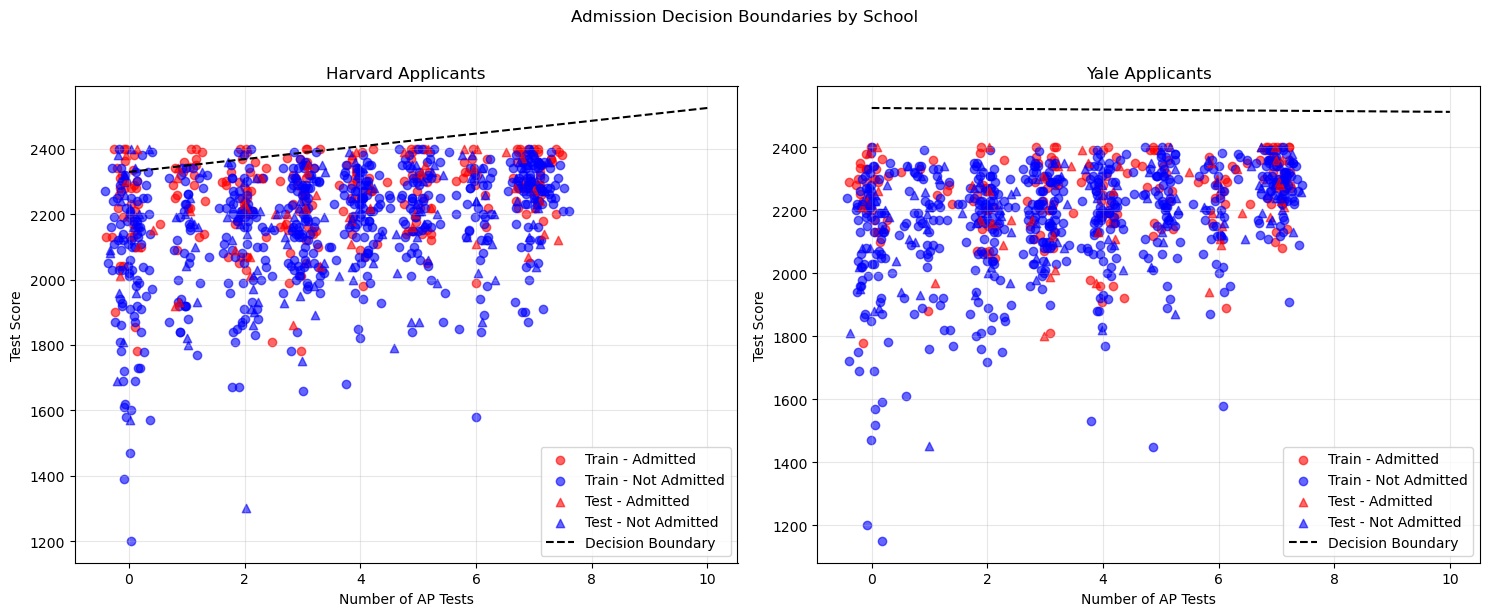

In [36]:
# subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# jitter to prevent overlapping
np.random.seed(42)
jitter = 0.2

"""
Harvard plot
"""
harvard_train = college_train[college_train['harvard'] == 1]
harvard_test = college_test[college_test['harvard'] == 1]

# Training data for Harvard - admitted
ax1.scatter(harvard_train[harvard_train['admitted']==1]['ap'] + np.random.normal(0, jitter, len(harvard_train[harvard_train['admitted']==1])),
           harvard_train[harvard_train['admitted']==1]['test_score'] + np.random.normal(0, jitter, len(harvard_train[harvard_train['admitted']==1])),
           color='red',
           marker='o',
           alpha=0.6,
           label='Train - Admitted')

# Training data for Harvard - not admitted
ax1.scatter(harvard_train[harvard_train['admitted']==0]['ap'] + np.random.normal(0, jitter, len(harvard_train[harvard_train['admitted']==0])),
           harvard_train[harvard_train['admitted']==0]['test_score'] + np.random.normal(0, jitter, len(harvard_train[harvard_train['admitted']==0])),
           color='blue',
           marker='o',
           alpha=0.6,
           label='Train - Not Admitted')

# Test data for Harvard - admitted
ax1.scatter(harvard_test[harvard_test['admitted']==1]['ap'] + np.random.normal(0, jitter, len(harvard_test[harvard_test['admitted']==1])),
           harvard_test[harvard_test['admitted']==1]['test_score'] + np.random.normal(0, jitter, len(harvard_test[harvard_test['admitted']==1])),
           color='red',
           marker='^',
           alpha=0.6,
           label='Test - Admitted')

# Test data for Harvard - not admitted
ax1.scatter(harvard_test[harvard_test['admitted']==0]['ap'] + np.random.normal(0, jitter, len(harvard_test[harvard_test['admitted']==0])),
           harvard_test[harvard_test['admitted']==0]['test_score'] + np.random.normal(0, jitter, len(harvard_test[harvard_test['admitted']==0])),
           color='blue',
           marker='^',
           alpha=0.6,
           label='Test - Not Admitted')

# Decision boundary for Harvard
ap_range = np.linspace(0, 10, 100)
test_scores_harvard = 2329.25 + 19.55 * ap_range
ax1.plot(ap_range, test_scores_harvard, 'k--', label='Decision Boundary')

ax1.set_title('Harvard Applicants')
ax1.set_xlabel('Number of AP Tests')
ax1.set_ylabel('Test Score')
ax1.legend()
ax1.grid(True, alpha=0.3)


"""
Yale plot
"""
yale_train = college_train[college_train['harvard'] == 0]
yale_test = college_test[college_test['harvard'] == 0]

# Training data for Yale - admitted
ax2.scatter(yale_train[yale_train['admitted']==1]['ap'] + np.random.normal(0, jitter, len(yale_train[yale_train['admitted']==1])),
           yale_train[yale_train['admitted']==1]['test_score'] + np.random.normal(0, jitter, len(yale_train[yale_train['admitted']==1])),
           color='red',
           marker='o',
           alpha=0.6,
           label='Train - Admitted')

# Training data for Yale - not admitted
ax2.scatter(yale_train[yale_train['admitted']==0]['ap'] + np.random.normal(0, jitter, len(yale_train[yale_train['admitted']==0])),
           yale_train[yale_train['admitted']==0]['test_score'] + np.random.normal(0, jitter, len(yale_train[yale_train['admitted']==0])),
           color='blue',
           marker='o',
           alpha=0.6,
           label='Train - Not Admitted')

# Test data for Yale - admitted
ax2.scatter(yale_test[yale_test['admitted']==1]['ap'] + np.random.normal(0, jitter, len(yale_test[yale_test['admitted']==1])),
           yale_test[yale_test['admitted']==1]['test_score'] + np.random.normal(0, jitter, len(yale_test[yale_test['admitted']==1])),
           color='red',
           marker='^',
           alpha=0.6,
           label='Test - Admitted')

# Test data for Yale - not admitted
ax2.scatter(yale_test[yale_test['admitted']==0]['ap'] + np.random.normal(0, jitter, len(yale_test[yale_test['admitted']==0])),
           yale_test[yale_test['admitted']==0]['test_score'] + np.random.normal(0, jitter, len(yale_test[yale_test['admitted']==0])),
           color='blue',
           marker='^',
           alpha=0.6,
           label='Test - Not Admitted')

# Decision boundary for Yale
test_scores_yale = 2524.72 - 1.23 * ap_range
ax2.plot(ap_range, test_scores_yale, 'k--', label='Decision Boundary')

ax2.set_title('Yale Applicants')
ax2.set_xlabel('Number of AP Tests')
ax2.set_ylabel('Test Score')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Add overall title
plt.suptitle('Admission Decision Boundaries by School', y=1.02)
plt.tight_layout()

plt.show()

<!-- END QUESTION -->

<div class='exercise-r'>

**Q3.6** Fit a logistic regression model (call it `logit3_6`) to predict `admitted` from 4 predictors: `["harvard", "test_score", "female", "minority"]` along with 2 interaction terms: `harvard` with `female` and `harvard` with `minority`. 

 - Store the train and mean cv accuracies in `acc_train_logit3_6` and `acc_cv_logit3_6`.
 - Display the accuracy scores.
</div>

In [37]:
# Provided code in Q3.7 will assume this order of predictors
logit3_6_predictors = ["harvard",
                       "test_score",
                       "female",
                       "minority",
                       "harvard_female",
                       "harvard_minority"
                      ]

In [38]:
# your code here
X_train["harvard_female"] = X_train["harvard"] * X_train["female"]
X_train["harvard_minority"] = X_train["harvard"] * X_train["minority"]
logit3_6 = LogisticRegression(penalty = None, random_state = seed, max_iter = 10000).fit(X_train[logit3_6_predictors], y_train)
acc_train_logit3_6 = logit3_6.score(X_train[logit3_6_predictors], y_train)
acc_cv_logit3_6 = cross_val_score(logit3_6, X_train[logit3_6_predictors], y_train, cv=10).mean()

In [39]:
print(
    "\nThe classification accuracies for 'logit3_6' are:"
    "\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(acc_train_logit3_6, acc_cv_logit3_6)
)


The classification accuracies for 'logit3_6' are:

	Train	0.7353
	CV	0.7279


In [40]:
grader.check("q3.6")

q3.6 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q3.7** Interpret the coefficients associated with `female` and `minority` (the two main effects AND the two interaction terms).
    
</div>

In [41]:
# Display results
logit3_6_intercept = np.array(logit3_6.intercept_).flatten()[0]
logit3_6_coefs = logit3_6.coef_.flatten()

print(
    "The intercept and coefficients for the 'logit3_6' model are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", logit3_6_intercept
    )
)

for predictor, coef in zip(logit3_6_predictors, logit3_6_coefs):
    print("\t{:<20}{:.4f}".format(predictor, coef))

The intercept and coefficients for the 'logit3_6' model are:

	intercept           -12.0758
	harvard             0.2784
	test_score          0.0049
	female              -0.1541
	minority            1.0975
	harvard_female      0.2329
	harvard_minority    -0.6182


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

First, let's discuss the main effect.
- female coefficient = -0.1541. This represents the base effect of being female when harvard = 0. Being female is associated with a 0.1541 decrease in log-odds of admission for a Yale applicant, holding all other variables constant.
- minority coefficient = 1.0975. This represents the base effect of being a minority when harvard = 0. Being from a minority group is associated with a 1.0975 increase in log-odds of admission, holding other variables constant.

Now, let's discuss the interaction effects.
- harvard_female coefficient = 0.2329. This represents how the effect of being female changes when applying to Harvard vs Yale. The effect on log-odds of admission of being female is 0.2329 greater for Harvard applicants compared to Yale applicants.
- harvard_minority coefficient = -0.6182. This represents how the effect of being a minority changes when applying to Harvard vs Yale. 
The effect on log-odds of admission of being a minority is 0.6182 less for Harvard applicants compared to Yale applicants.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q3.8** Based on this model, how does it appear that Harvard and Yale compare in admitting women and minorities?  Given what we've seen in our previous analysis, what might be some reasons we have to doubt the interpretation of the model's coefficients as reflecting the truth?

</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

Based on this model, Yale appears less likely to admit women applicants while Harvard appears more likely to admit women applicants. However, Yale appears to have a stronger positive preference for minority applicants compared to Harvard.
Both schools show positive effects for minority applicants, but Yale's effect appears substantially larger.

However, there are several reasons to doubt this interpretations. First, as mentioned earlier, the data only includes students who chose to post their stats to the website, which means the data might not reflect the entire pool of applicants.

Second, and more importantly, the model doesn't actually seem to do such a great job predicting whether a student will get admitted or not. Indeed, in cross validation, the model only gets about 70 percent of the classification correct. This is roughly the exact same as the naive classification method, which literally just rejects all applicants! Clearly, our model is not capturing some effect that distinguishes worthy applicants from unworthy ones --- something like number and quality of extracurricular activities.

Finally, the predictors are not scaled, which makes it difficult to directly compare the coefficients to understand relative importance.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

---

<a id="part4"></a>

## <div class='exercise'>Question 4: Building predictive models for admitted</div>

[Return to contents](#contents)

<div class='exercise-r'>

**Q4.1** You were instructed to NOT scale predictors in the prior sections above. The primary reason for this was to focus instead on the interpretability of our logistic regression coefficients. However, as we're sure you noticed, the numeric scale among our different predictors varies greatly (i.e. `test_score` values are in the 1,000's while others are much, much smaller). In practice, we might want to put our predictors all on a similar scale, particularly for regularized regression and/or distance-based algorithms such as $k$-NN classification. 

1. Explain why scaling under these circumstances might be important.
2. Define a list of all non-binary predictors from the original set of 12 predictors, calling it `non_binary_predictors`.
3. Apply standardized scaling to all of these **non-binary** predictors. **For the sake of consistency, fit your scaler on just the training data. Then use it to transform both train and test.**

**IMPORTANT:** These scaled predictors should be used instead of the original unscaled versions of the predictors for the remainder of this problem set. Tests from this point on assume that `X_train` and `X_test` have been standardized with the approach outlined above. 

</div>

Scaling is important for both regularized regression and for kNN classification.

For regularized regression, regularization penalizes large coefficients. Without scaling, variables with larger magnitudes (like test_score) would be penalized more heavily than variables with smaller magnitudes. This would unfairly shrink the coefficients of large-scale variables more than small-scale variables. Scaling puts all variables on the same scale so regularization treats them equally.

For kNN, k-NN uses distance calculations between points. Variables with larger magnitudes would dominate the distance calculations. For example, a difference of 100 points in test_score would overwhelm differences in number of AP tests. Scaling ensures each variable contributes proportionally to distance calculations.

In [42]:
# your code here
non_binary_predictors = ["test_score", "ap", "avg_ap", "sat_subjects", "gpa"]

# apply standard scaler to non-binary predictors
scaler = StandardScaler()

# Fit scaler on training data and transform both train and test
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Fit on training data only
scaler.fit(X_train[non_binary_predictors])

# Transform both train and test sets
X_train_scaled[non_binary_predictors] = scaler.transform(X_train[non_binary_predictors])
X_test_scaled[non_binary_predictors] = scaler.transform(X_test[non_binary_predictors])

# Assign these back to X_train and X_test
X_train = X_train_scaled
X_test = X_test_scaled

In [43]:
# preview summary stats after standardizing
X_train.describe()

,test_score,ap,avg_ap,sat_subjects,gpa,female,minority,international,sports,early_app,alumni,harvard,harvard_test_score,harvard_ap,harvard_female,harvard_minority
count,1.496e+03,1.496e+03,1.496e+03,1.496e+03,1.496e+03,1496.000,1496.000,1496.000,1496.000,1496.000,1496.000,1496.000,1496.000,1496.000,1496.000,1496.000
mean,5.343e-16,3.800e-17,1.639e-16,1.615e-16,-4.180e-16,0.511,0.215,0.061,0.035,0.172,0.046,0.519,1133.842,1.780,0.255,0.118
std,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,0.500,0.411,0.239,0.185,0.378,0.210,0.500,1099.344,2.402,0.436,0.323
min,-6.125e+00,-1.470e+00,-2.159e+00,-2.262e+00,-9.703e+00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,-4.540e-01,-6.091e-01,-1.203e-01,-6.917e-01,-2.008e-01,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,1.958e-01,-1.787e-01,4.205e-01,9.342e-02,3.612e-01,1.000,0.000,0.000,0.000,0.000,0.000,1.000,1825.000,0.000,0.000,0.000
75%,7.275e-01,6.822e-01,6.909e-01,9.342e-02,6.167e-01,1.000,0.000,0.000,0.000,0.000,0.000,1.000,2230.000,3.000,1.000,0.000
max,1.259e+00,1.543e+00,7.533e-01,2.449e+00,6.167e-01,1.000,1.000,1.000,1.000,1.000,1.000,1.000,2400.000,7.000,1.000,1.000


In [44]:
grader.check("q4.1")

q4.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q4.2** Fit a well-tuned $k$-NN classification model with main effects of all 12 predictors in it (call it `knn_model`).  Use `ks = range(1, 50, 2)` and 10-fold cross-validation with classification accuracy as the scoring metric. Plot, on a single set of axes, your resulting cross-validation mean training and mean validation scores at each value $k$. Then, store your chosen $k$ in `best_k`, the accuracy on the best model when refit on all the training data in `knn_train_acc`, and the mean 10-fold CV accuracy of the best model in `knn_cv_acc`.
    
</div>

In [45]:
ks = range(1, 50, 2)
train_scores = []
cv_scores = []
predictors = ["test_score", "ap", "avg_ap", "sat_subjects", "gpa", "female", "minority", "international", "sports", "harvard", "early_app", "alumni"]

# iterate over ks
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k).fit(X_train[predictors], y_train)
    
    # get training scores
    train_score = knn.score(X_train[predictors], y_train)
    train_scores.append(train_score)
    
    # get CV scores
    cv_score = cross_val_score(knn, X_train[predictors], y_train, cv=10).mean()
    cv_scores.append(cv_score)
    
# k that gives highest cv score
best_k = ks[np.argmax(cv_scores)]

# fit model with best k
knn_model = KNeighborsClassifier(n_neighbors=best_k).fit(X_train[predictors], y_train)
knn_train_acc = knn_model.score(X_train[predictors], y_train)
knn_cv_acc = max(cv_scores)

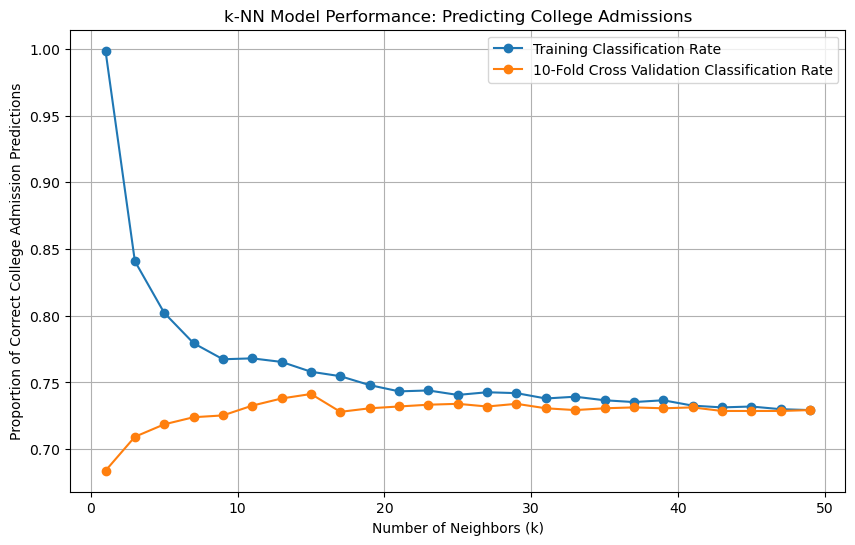

In [46]:
# Plot cross-validation results
plt.figure(figsize=(10, 6))
plt.plot(ks, train_scores, label='Training Classification Rate', marker='o')
plt.plot(ks, cv_scores, label='10-Fold Cross Validation Classification Rate', marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Proportion of Correct College Admission Predictions')
plt.title('k-NN Model Performance: Predicting College Admissions')
plt.legend()
plt.grid(True)
plt.show()

In [47]:
print(
    "The classification accuracies for 'knn_model' where k={} "
    "are:\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(
        best_k, knn_train_acc, knn_cv_acc
    )
)
# create dict for storing test scores for each Q4 model
q4_cv_scores = {"knn_model": knn_cv_acc}

The classification accuracies for 'knn_model' where k=15 are:

	Train	0.7580
	CV	0.7413


<!-- END QUESTION -->

<div class='exercise-r'>

**Q4.3** Fit the full logistic regression model (without penalty) with main effects of all 12 predictors in it (call it `logit_full`). Store the train mean cv accuracy in `logit_full_train_acc` and `logit_full_cv_acc`.

**HINT:** If you have convergence warnings, increasing the maximum number of iterations will likely solve this issue.
    
</div>

In [48]:
# The code that prints your results assumes
# predictors were given to the model in this order
predictor_list = [
    "test_score", "ap", "avg_ap", "sat_subjects",
    "gpa", "female", "minority", "international",
    "sports", "harvard", "early_app", "alumni",
]

In [49]:
# your code here
logit_full = LogisticRegression(penalty = None, random_state = seed, max_iter = 10000).fit(X_train[predictor_list], y_train)
logit_full_train_acc = logit_full.score(X_train[predictor_list], y_train)
logit_full_cv_acc = cross_val_score(logit_full, X_train[predictor_list], y_train, cv=10).mean()

In [50]:
# display your results
print(
    "The intercept and coefficients for the 'logit_full' model are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", np.array(logit_full.intercept_).flatten()[0]
    )
)

for predictor, coef in zip(predictor_list, logit_full.coef_.flatten()):
    print("\t{:<20}{:.4f}".format(predictor, coef))

print(
    "\nThe classification accuracies for 'logit_full' are:"
    "\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(logit_full_train_acc, logit_full_cv_acc)
)

# store test score to dict for later use
q4_cv_scores["logit_full"] = logit_full_cv_acc

The intercept and coefficients for the 'logit_full' model are:

	intercept           -1.7415
	test_score          0.8893
	ap                  -0.1284
	avg_ap              0.0008
	sat_subjects        -0.0976
	gpa                 0.0697
	female              -0.0175
	minority            0.8088
	international       0.3067
	sports              1.0388
	harvard             0.3949
	early_app           0.6029
	alumni              0.8664

The classification accuracies for 'logit_full' are:

	Train	0.7447
	CV	0.7373


In [51]:
grader.check("q4.3")

q4.3 results: All test cases passed!

<div class='exercise-r'>

**Q4.4** Fit a well-tuned Lasso-like logistic regression model from all 12 predictors in it (call it `logit_lasso`). Use `Cs = np.logspace(-2, 2, 50)` and 10-fold cross-validation. Store the train and mean cross-validation accuracies in `logit_lasso_train_acc` and `logit_lasso_cv_acc`. For tuning a regularized logistic regression model, you should use `LogisticRegressionCV`. But again, to insure reproducability here, you should set `random_state=109`. 

**Hint:**
- The default solver for SKLearn's logistic regression, 'lbfgs', is not compatible with LASSO regularization, so you will need to use a different solver here. See the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) for guidance.

</div>

In [52]:
Cs = np.logspace(-2, 2, 50)

# your code here
logit_lasso = LogisticRegressionCV(penalty='l1', solver='liblinear', random_state=seed, Cs=Cs, cv=10, max_iter=10000).fit(X_train[predictor_list], y_train)
logit_lasso_train_acc = logit_lasso.score(X_train[predictor_list], y_train)
# get index of best C value
best_C_idx = np.where(Cs == logit_lasso.C_[0])[0][0]

# get CV accuracy for best C
logit_lasso_cv_acc = logit_lasso.scores_[1].mean(axis=0)[best_C_idx]

In [53]:
# Display your results
print(
    "The intercept and coefficients for the 'logit_lasso' model are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", np.array(logit_lasso.intercept_).flatten()[0]
    )
)

# Again, this code assumes predictors were given to the model
# in the order defined in `predictor_list`
for predictor, coef in zip(predictor_list, logit_lasso.coef_.flatten()):
    print("\t{:<20}{:.4f}".format(predictor, coef))

print(
    "\nThe classification accuracies for 'logit_lasso' are:"
    "\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(logit_lasso_train_acc, logit_lasso_cv_acc)
)

# store cv score to dict for later use
q4_cv_scores["logit_lasso"] = logit_lasso_cv_acc

The intercept and coefficients for the 'logit_lasso' model are:

	intercept           -1.5207
	test_score          0.8187
	ap                  -0.0967
	avg_ap              -0.0240
	sat_subjects        -0.0689
	gpa                 0.0283
	female              -0.0029
	minority            0.6527
	international       0.0000
	sports              0.5988
	harvard             0.2628
	early_app           0.4534
	alumni              0.6012

The classification accuracies for 'logit_lasso' are:

	Train	0.7420
	CV	0.7380


In [54]:
grader.check("q4.4")

q4.4 results: All test cases passed!

<div class='exercise-r'>

**4.5** Which predictors were deemed important in `logit_lasso`?  Which were deemed unimportant? Here we assume that any predictors with zero-valued Lasso coefficients "unimportant". Store your results in `predictors_important` and `predictors_not_important`.
 
</div>

In [55]:
predictors_important = ["test_score", "ap", "avg_ap", "sat_subjects", "gpa", "female", "minority", "sports", "harvard", "early_app", "alumni"]
predictors_not_important = ["international"]

In [56]:
# display results
print(
    "The following predictors were deemed important by "
    "'logit_lasso' (i.e. coef != 0):\n\n\t{}\n\n\n"
    "While, the remaining were deemed unimportant (i.e. "
    "coef == 0):\n\n\t{}"
    .format(
        predictors_important,
        predictors_not_important,
    )
)

The following predictors were deemed important by 'logit_lasso' (i.e. coef != 0):

	['test_score', 'ap', 'avg_ap', 'sat_subjects', 'gpa', 'female', 'minority', 'sports', 'harvard', 'early_app', 'alumni']


While, the remaining were deemed unimportant (i.e. coef == 0):

	['international']


In [57]:
grader.check("q4.5")

q4.5 results: All test cases passed!

<div class='exercise-r'>

**Q4.6** Fit a well-tuned Lasso-like logistic regression model with all important predictors from `logit_lasso` and all the unique 2-way interactions between them (call it `lasso_interact`).  Again use `Cs = np.logspace(-2, 2, 50)`,  and 10-fold cross-validation with classification accuracy as the scoring metric. Record the accuracy on train and test for this model in `lasso_interact_train_acc` and `lasso_interact_test_acc`.

</div>

In [58]:
# create interaction terms
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X_train_interact = poly.fit_transform(X_train[predictors_important])
X_test_interact = poly.transform(X_test[predictors_important])


In [59]:
Cs = np.logspace(-2, 2, 50)

lasso_interact = LogisticRegressionCV(penalty='l1', solver='liblinear', random_state=seed, Cs=Cs, cv=10, max_iter=10000).fit(X_train_interact, y_train)
lasso_interact_train_acc = lasso_interact.score(X_train_interact, y_train)

# get index of best C value
best_C_idx = np.where(Cs == lasso_interact.C_[0])[0][0]

# get CV accuracy for best C
lasso_interact_cv_acc = lasso_interact.scores_[1].mean(axis=0)[best_C_idx]

In [60]:
print(
    "\nThe classification accuracies for 'logit_lasso_interact' are:"
    "\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}\n"
    .format(lasso_interact_train_acc, lasso_interact_cv_acc)
)

# store test score to dict for later use
q4_cv_scores["lasso_interact"] = lasso_interact_cv_acc


The classification accuracies for 'logit_lasso_interact' are:

	Train	0.7547
	CV	0.7386



<div class='exercise-r'>

**Q4.7** How many of the predictors in our `logit_lasso_interact` model were deemed important and unimportant? Store these numbers in `num_important_coefs` and `num_unimportant_coefs`. 
    
</div>

In [61]:
# get feature names and coefs; both original and interactions
feature_names = poly.get_feature_names_out(predictors_important)
coefs = lasso_interact.coef_[0]

# print
print("Features and their coefficients")
print("Feature".ljust(30) + "Coefficient")
print("-" * 45)
for feat, coef in zip(feature_names, coefs):
   print(f"{feat.ljust(30)} {coef:>10.4f}")


Features and their coefficients
Feature                       Coefficient
---------------------------------------------
test_score                         0.7175
ap                                 0.0000
avg_ap                            -0.2107
sat_subjects                       0.0000
gpa                                0.0827
female                            -0.1347
minority                           0.9686
sports                             0.8106
harvard                            0.2748
early_app                          0.5005
alumni                             0.7005
test_score ap                      0.0000
test_score avg_ap                  0.0079
test_score sat_subjects           -0.0842
test_score gpa                     0.1266
test_score female                  0.0706
test_score minority                0.0000
test_score sports                 -0.1073
test_score harvard                 0.1786
test_score early_app              -0.0546
test_score alumni                  0.352

In [62]:
num_important_coefs = np.count_nonzero(coefs)
num_unimportant_coefs = coefs.size - np.count_nonzero(coefs)

In [63]:
print(
    "Of the {} predictors used in our 'logit_lasso_interact' model:"
    "\n\n\t{} predictors were deemed 'important' by our model"
    "\n\t{} predictors were deemed 'unimportant' with 0-valued "
    "coefficients".format(
        num_important_coefs + num_unimportant_coefs,
        num_important_coefs,
        num_unimportant_coefs
    )
)

Of the 66 predictors used in our 'logit_lasso_interact' model:

	44 predictors were deemed 'important' by our model
	22 predictors were deemed 'unimportant' with 0-valued coefficients


In [64]:
grader.check("q4.7")

q4.7 results: All test cases passed!

---

<a id="part5"></a>

## <div class='exercise'>Question 5: Evaluating results</div>

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q5.1** Which of the 4 models in Question 4 performs the best based on cross-validation accuracy?  Which performs the worst? Based on these accuracies, how do these models perform compared to your baseline "naive" model's performance on the training data back in Question 1.1? What does this comparison to the "naive" model tell us?
    
</div>

In [65]:
# your code here
print("The CV accuracies for the 4 models in Q4 are:\n")
for key, value in q4_cv_scores.items():
    print("\t{:<25}{:.4f}".format(key, value))
print(
    "\nThe  accuracy for our original baseline \"naive\" "
    "model was {:.4f}".format(naive_train_acc)
)

The CV accuracies for the 4 models in Q4 are:

	knn_model                0.7413
	logit_full               0.7373
	logit_lasso              0.7380
	lasso_interact           0.7386

The  accuracy for our original baseline "naive" model was 0.7299


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

The best model is knn, which has cross validation accuracy of 0.7413. The worst model is the logit_full, which has cross validation accuracy of 0.7373.

The naive model had an accuracy of 0.7299. Thus, all four models in question 4 perform better than the naive baseline, but the improvement is relatively small. The best model, knn, only improves by 0.0114.

The small improvement over the naive model suggests that predicting college admissions is a challenging task where even sophisticated models struggle to perform much better than simple approaches. It could be that there are important factors not captured in our predictors, such as essays, recommendations, and extracurriculars. It could also be that admission decisions might have an inherent level of randomness / subjectivity.

The similar performance across all models suggests that additional model complexity isn't really adding much predictive power and that we might be approaching the maximum predictive accuracy possible with these variables.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q5.2** Draw an ROC curve for each of the four models on a single plot.  How do these ROC curves compare?  Do the ROC curves support that the best model identified in Question 5.1 is better than the worst model identified in 5.1?  How do you know?

**Hint:** Use `cross_val_predict` with `method='predict_proba` to get the probability predictions required to construct the ROC curves.
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

The ROC curves do not support that the best model identified above (the knn model) is better than the worst model (logistic full). The On the ROC curves, each point represents a different threshold for classifying a student as admitted vs not admitted. A perfect classifier would go through (0,1), which means all true positives and no false positives. Likewise, a random classifier would follow a diagonal line, where there is an equal trade-off between the TPR and FPR for all decision thresholds. Better classifiers curve toward top-left corner.

In the graph below, the best model identified in 5.1 is actually less curvy toward (0,1) than all the logistic regressions. Earlier, we simply used the 0.5 threshold to indentify the error. But while kNN might perform better at the specific 0.5 threshold (as evidenced by its higher accuracy), the logistic models perform better across the full range of possible thresholds, as shown by their better ROC curves.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

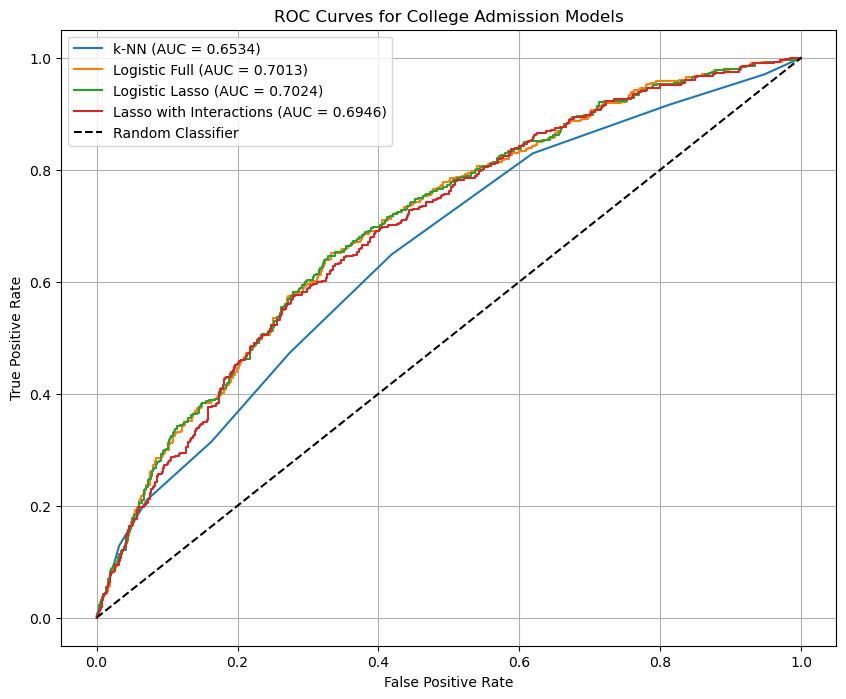

In [66]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, auc

# get probability predictions for each model using cross_val_predict
knn_probs = cross_val_predict(knn_model, X_train[predictors], y_train, method='predict_proba', cv=10)[:, 1]
logit_full_probs = cross_val_predict(logit_full, X_train[predictor_list], y_train, method='predict_proba', cv=10)[:, 1]
logit_lasso_probs = cross_val_predict(logit_lasso, X_train[predictor_list], y_train, method='predict_proba', cv=10)[:, 1]
lasso_interact_probs = cross_val_predict(lasso_interact, X_train_interact, y_train, method='predict_proba', cv=10)[:, 1]

# calculate ROC
fpr_knn, tpr_knn, _ = roc_curve(y_train, knn_probs)
fpr_full, tpr_full, _ = roc_curve(y_train, logit_full_probs)
fpr_lasso, tpr_lasso, _ = roc_curve(y_train, logit_lasso_probs)
fpr_interact, tpr_interact, _ = roc_curve(y_train, lasso_interact_probs)

# calculate AUC
auc_knn = auc(fpr_knn, tpr_knn)
auc_full = auc(fpr_full, tpr_full)
auc_lasso = auc(fpr_lasso, tpr_lasso)
auc_interact = auc(fpr_interact, tpr_interact)

# plot curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_knn, tpr_knn, label=f'k-NN (AUC = {auc_knn:.4f})')
plt.plot(fpr_full, tpr_full, label=f'Logistic Full (AUC = {auc_full:.4f})')
plt.plot(fpr_lasso, tpr_lasso, label=f'Logistic Lasso (AUC = {auc_lasso:.4f})')
plt.plot(fpr_interact, tpr_interact, label=f'Lasso with Interactions (AUC = {auc_interact:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for College Admission Models')
plt.legend()
plt.grid(True)
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**5.3** Calculate the AUC for all 4 models and store these in `auc_list`. **The order of AUCs in the list should match the order of the model as they appear in `q4_cv_scores`.**
    
Do the rankings of these 4 models based on AUC match those for classification accuracy?  Why do you think this is the case?
    
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

No, the rankings based on AUC and accuracy don't match. The kNN model shows this discrepancy the largest. It wins in accuracy but loses in AUC. This occurs because accuracy only considers performance at 0.5 threshold, whereas AUC considers performance across all thresholds.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [67]:
auc_list = [auc_knn, auc_full, auc_lasso, auc_interact]

In [68]:
print(
    "The CV accuracies & CV AUC scores for the 4 models in Q4 are:"
    "\n\n\t\t\t\tAccuracy\tAUC"
)
for (key, value), auc_value in zip(q4_cv_scores.items(), auc_list):
    print("\t{:<24}{:.4f}\t\t{:.4f}".format(key, value, auc_value))

The CV accuracies & CV AUC scores for the 4 models in Q4 are:

				Accuracy	AUC
	knn_model               0.7413		0.6534
	logit_full              0.7373		0.7013
	logit_lasso             0.7380		0.7024
	lasso_interact          0.7386		0.6946


In [69]:
grader.check("q5.3")

q5.3 results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q5.4** Select your preferred model based on the cross-validation accuracy and AUC. For this 'final model', display the accuracy and AUC scores on the **test data**. Compare these to the accuracy and AUC score of the naive model from 1.1 when predicting on the test data. Would you offer your final model as a publicly available tool for college applicants to use to determine their chances of getting into Harvard and/or Yale? Why or why not? What might be some consequences of the deployment of the model into the real world?
    
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

Based on these metrics, I would select logit_lasso as the preferred model because:
- it has the highest cross validation AUC --- 0.7024 ---  suggesting that it has a solid overall discriminative ability across multiple thresholds
- it's simpler and more interpretable than the interaction model

However, I would not deploy this to production. The model doesn't capture crucial qualitative factors. In addition, it is trained on poor data. It is not a representative sample of people who are applying to thes two colleges. And finally, the model doesn't actually do that great a job at accurately classifying people. It only does marginally better than the naive model, which naively rejects everyone. Finally, there is the fact that it seems mildly unethical to publsih it. Students might make life decisions based on incomplete/inaccurate prediction and it might lead to increased anxiety and stress about the college admision procfess.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [83]:
# get test accuracies
knn_test_acc = knn_model.score(X_test[predictors], y_test)
logit_full_test_acc = logit_full.score(X_test[predictor_list], y_test)
logit_lasso_test_acc = logit_lasso.score(X_test[predictor_list], y_test)
lasso_interact_test_acc = lasso_interact.score(X_test_interact, y_test)

# get test AUCs
knn_test_probs = cross_val_predict(knn_model, X_test[predictors], y_test, method='predict_proba', cv=10)[:, 1]
logit_full_test_probs = cross_val_predict(logit_full, X_test[predictor_list], y_test, method='predict_proba', cv=10)[:, 1]
logit_lasso_test_probs = cross_val_predict(logit_lasso, X_test[predictor_list], y_test, method='predict_proba', cv=10)[:, 1]
lasso_interact_test_probs = cross_val_predict(lasso_interact, X_test_interact, y_test, method='predict_proba', cv=10)[:, 1]

knn_test_auc = roc_auc_score(y_test, knn_test_probs)
logit_full_test_auc = roc_auc_score(y_test, logit_full_test_probs)
logit_lasso_test_auc = roc_auc_score(y_test, logit_lasso_test_probs)
lasso_interact_test_auc = roc_auc_score(y_test, lasso_interact_test_probs)

print("Test Set Performance:")
print("Model".ljust(20) + "Accuracy".ljust(15) + "AUC")
print("-" * 45)
print(f"kNN".ljust(20) + f"{knn_test_acc:.4f}".ljust(15) + f"{knn_test_auc:.4f}")
print(f"Logistic Full".ljust(20) + f"{logit_full_test_acc:.4f}".ljust(15) + f"{logit_full_test_auc:.4f}")
print(f"Logistic Lasso".ljust(20) + f"{logit_lasso_test_acc:.4f}".ljust(15) + f"{logit_lasso_test_auc:.4f}")
print(f"Lasso Interact".ljust(20) + f"{lasso_interact_test_acc:.4f}".ljust(15) + f"{lasso_interact_test_auc:.4f}")
print(f"Naive".ljust(20) + f"{0.7307}" + f"{0.5}".ljust(15))

Test Set Performance:
Model               Accuracy       AUC
---------------------------------------------
kNN                 0.7333         0.5900
Logistic Full       0.7253         0.6353
Logistic Lasso      0.7440         0.5626
Lasso Interact      0.7253         0.4986
Naive               0.73070.5            


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<a id="part6"></a>

## <div class='exercise'>Question 6: BONUS!</div>

[Return to contents](#contents)

<div class='exercise-r'>

**Q6 (optional)** Incorporate what you've learned from the PCA and/or Missingness sections of the course to create a new, improved classification model. You could focus on improving predictive performance, inference, interpretability, or all of the above! 

Be sure to also describe your approach and analyze your results.

While this section is optional, we highly encourge you to experiment (and not just for the sake of the potential bonus points 😉).

**Note:** Though you should report the test performance of this new, "bonus" model, selecting the bonus model over the 'final model' from Q5.4 would have to be justified based on cross-validation performance, *not* test performance! 
    
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

Here is a summary of my approach. First, I applid Principal Component Analysis to the numeric predictors in order to reduce dimensionality while retaining key information. I selected enough principal components to explain at least eighty percent of the variance in the original numeric predictors --- turns out, this is three PCs. Then, I combined the three PCs with the categorical predicotrs in their original form and fit a Lasso logistic regression model, similar to the one that I selected above.

The results are below.
- Cross Validation Accuracy: 0.7400
- Test Accuracy: 0.7307
- Test AUC: 0.6481

The cross validation performance is competitive with that of our previous best model --- the lasso with important predictors. Furthermore, the test AUC is actually better than all previous models. This suggests that dimension reduction has reduced noise in numeric predictors. I would prefer this model over the previous best model, given that accuracy levels are similar, and AUC is better. Interpretability also isn't worse at all -- the PCA components measure the main patterns in academic metrics, and the categorical variables are the same as they were before.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [71]:
from sklearn.decomposition import PCA

# apply PCA to all numeric predictors
numeric_predictors = ["test_score", "ap", "avg_ap", "sat_subjects", "gpa"]
categorical_predictors = ["female", "minority", "international", "sports", "harvard", "early_app", "alumni"]
pca = PCA()
X_train_pca = pca.fit_transform(X_train[numeric_predictors])
X_test_pca = pca.transform(X_test[numeric_predictors])

# Look at explained variance to choose number of components
print("Explained variance ratios:", pca.explained_variance_ratio_)


Explained variance ratios: [0.44908787 0.20880813 0.16202856 0.11212614 0.06794929]


In [72]:

# we want to explain 80 percent of the variance, so we pick three PCs
n_components = 3
pca = PCA(n_components=n_components)
pca.fit(X_train[numeric_predictors])
X_train_numeric_pca = pca.transform(X_train[numeric_predictors])
X_test_numeric_pca = pca.transform(X_test[numeric_predictors])
X_train_pca_combined = np.column_stack([X_train_numeric_pca, X_train[categorical_predictors]])
X_test_pca_combined = np.column_stack([X_test_numeric_pca, X_test[categorical_predictors]])


# fit lasso logistic regression on the three PCA components
Cs = np.logspace(-2, 2, 50)
logit_pca = LogisticRegressionCV(penalty='l1', solver='liblinear', random_state=seed, Cs=Cs, cv=10, max_iter=10000).fit(X_train_pca_combined, y_train)

# get train accuracy
logit_pca_train_acc = logit_pca.score(X_train_pca_combined, y_train)

# get cv accuracy
best_C_idx = np.where(Cs == logit_pca.C_[0])[0][0]
logit_pca_cv_acc = logit_pca.scores_[1].mean(axis=0)[best_C_idx]

# get test accuracy
logit_pca_test_acc = logit_pca.score(X_test_pca_combined, y_test)

# get test AUC
logit_pca_test_probs = logit_pca.predict_proba(X_test_pca_combined)[:, 1]
logit_pca_test_auc = roc_auc_score(y_test, logit_pca_test_probs)

print("\nPCA Model Test Performance:")
print(f"Cross Validation Accuracy: {logit_pca_cv_acc:.4f}")
print(f"Test Accuracy: {logit_pca_test_acc:.4f}")
print(f"Test AUC: {logit_pca_test_auc:.4f}")


PCA Model Test Performance:
Cross Validation Accuracy: 0.7400
Test Accuracy: 0.7307
Test AUC: 0.6481


<!-- END QUESTION -->

<div class="alert alert-info" style="color: #4a4a4a; background-color: #fbe8ff; border-color: #eed4db; border-width: 1px; border-radius: 3px; padding: 10px;">

**Wrap-up**

* Please describe the aspect(s) of the assignment you found most challenging. This could be conceptual and/or related to coding and implementation. This is also a good place to ask any remaining questions you may have.

* How many hours did you spend working on this assignment? Store this as an int or float in `hours_spent_on_hw`. If you worked on the project in a group, report the *average* time spent per person.

</div>

In [73]:
hours_spent_on_hw = 10

In [74]:
grader.check("wrapup")

wrapup results: All test cases passed!

In [75]:
notebook_end = time.time()
print(f"It took {(notebook_end - notebook_start)/60:.2f} minutes for this notebook to run")

It took 0.69 minutes for this notebook to run


🌈 **This concludes HW5. Thank you!**

[Return to contents](#contents)